In [1]:
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import astropy.table as tab
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras                                                                                                                                         
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout                                                                                    
from tensorflow.keras.optimizers import Adam                                                                                                                         
from tensorflow.keras.callbacks import EarlyStopping 


In [2]:
# Load the data and preprocess the labels as shown above
#data_table = tab.Table.read('/content/drive/MyDrive/Colab-Notebooks/workshop_planet_local.fits')
data_table = tab.Table.read('workshop_planet_local.fits')


In [3]:
data_table

id,class,local [201],av_training_set,depth,duration,impact,period,max_mult_ev,model_snr,plnt_num,time0bk,spline_bkspace
int64,bytes3,float64,bytes3,float64,float64,float64,float64,float64,float64,int64,float64,float64
6507433,PC,-0.003685545176267624 .. 0.049602705985307693,PC,3522.0,0.05329166725277901,0.9376999735832214,4.742549896240234,91.80000305175781,106.30000305175781,1,133.13800048828125,0.5
10272640,PC,-0.0009759697713889182 .. -0.003937867935746908,PC,13170.0,0.15862500667572021,0.06650999933481216,3.770550012588501,658.5,639.2999877929688,1,134.656005859375,0.5
9761573,PC,-0.014799775555729866 .. 0.03045441210269928,PC,2207.0,0.11837500333786011,1.0,7.441659927368164,63.369998931884766,59.81999969482422,1,137.3090057373047,0.8952139616012573
10352938,PC,0.0001071926235454157 .. 0.0107777314260602,AFP,6161.0,0.29762500524520874,0.34470000863075256,6.471749782562256,255.3000030517578,260.70001220703125,1,136.3520050048828,0.7372382879257202
6946199,PC,-0.004892205819487572 .. -0.042620230466127396,PC,1350.0,0.23079167306423187,0.29980000853538513,37.101200103759766,48.47999954223633,50.189998626708984,2,147.8730010986328,20.0
10583066,PC,-0.0829419493675232 .. 0.02255663089454174,PC,1896.0,0.06616666913032532,0.3499000072479248,6.029300212860107,54.720001220703125,64.80999755859375,1,135.42799377441406,5.138038635253906
11027624,PC,-0.006467259488999844 .. 0.0021557530853897333,PC,1997.0,1.00041663646698,0.3253999948501587,394.625,76.05999755859375,107.69999694824219,1,177.8459930419922,1.9462679624557495
5640085,PC,0.043257515877485275 .. -0.06920187175273895,PC,1182.0,0.11366666853427887,0.7210999727249146,10.139599800109863,51.7599983215332,56.779998779296875,1,137.89199829101562,0.8952139616012573
2989404,PC,-0.011556240729987621 .. 0.04006163403391838,PC,133.39999389648438,0.09537500143051147,0.5020999908447266,1.678320050239563,53.66999816894531,59.63999938964844,2,132.697998046875,2.3633148670196533


A subset of data taken from Shallue & Vandenburg 2018 (https://ui.adsabs.harvard.edu/abs/2018AJ....155...94S/abstract).

The first step in the 'data preparation' is to phase-fold each light curve using a pipeline that determines the period. Next, a region centered on the transit is selected. The size of this region is a fixed multiple of the transit duration. This region is divided into 201 bins of equal size, and the flux in each bin is then normalized to have a median value of 0 and a maximum depth of -1.


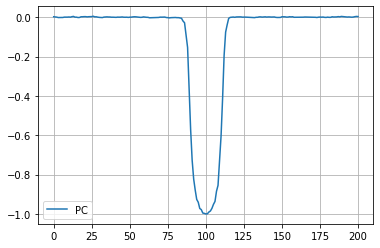

In [4]:
# random example plots
i = 42
plt.plot(data_table['local'][i], label = data_table['class'][i])
plt.legend()
plt.grid()
plt.show()

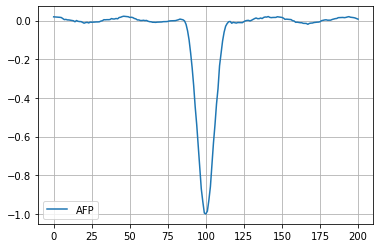

In [5]:
# random example plots
i = 52
plt.plot(data_table['local'][i], label = data_table['class'][i])
plt.legend()
plt.grid()
plt.show()

In [6]:
input_data = np.array(data_table['local'].tolist())

# PC == Planet candidate &  AFP =  Astrophysical False Positives
labels = np.where(data_table['class'] == 'PC', 0, 1)

In [7]:
input_data

array([[-0.00368555,  0.00375317,  0.01159763, ...,  0.03120879,
         0.03120879,  0.04960271],
       [-0.00097597, -0.00297161, -0.00210246, ..., -0.00151494,
        -0.0019131 , -0.00393787],
       [-0.01479978,  0.03045441,  0.03045441, ...,  0.03916331,
         0.03045441,  0.03045441],
       ...,
       [ 0.00931278,  0.00620852,  0.00299722, ...,  0.00085635,
        -0.00042817,  0.00064226],
       [ 0.00467737,  0.00580445,  0.00580445, ..., -0.00636799,
        -0.00636799,  0.00383207],
       [ 0.00093969, -0.00484948, -0.00481592, ..., -0.00761822,
        -0.00605766, -0.00625902]])

In [8]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [9]:
# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.2, random_state=1)


In [10]:
X_train


array([[-5.01807663e-05, -5.01807663e-05,  6.55957706e-07, ...,
         1.00033554e-04,  2.71238503e-04,  6.06760877e-05],
       [-1.13098860e-01, -8.08794573e-02, -3.87133695e-02, ...,
         5.19875474e-02,  7.33478833e-03,  1.04118213e-02],
       [-2.53590348e-04, -4.80947201e-04, -4.80947201e-04, ...,
         6.24648388e-03,  3.99623392e-03,  3.44241597e-03],
       ...,
       [-1.41637493e-02, -1.19244326e-02, -9.86707956e-03, ...,
        -4.59602801e-03, -4.74570692e-03, -1.30308839e-03],
       [ 1.63372327e-02, -4.73981444e-03, -1.31101254e-03, ...,
         4.84066177e-03, -2.74808388e-02, -2.23376360e-02],
       [ 1.04430383e-02, -1.01265823e-02,  2.84810131e-03, ...,
        -1.39240511e-02,  5.56962043e-02,  5.00000007e-02]])

In [11]:
# Reshape the input data to match the input shape expected by the CNN
X_train = X_train.reshape(-1, 201, 1)
X_test = X_test.reshape(-1, 201, 1)

In [12]:
X_train.shape

(800, 201, 1)

In [13]:
X_train

array([[[-5.01807663e-05],
        [-5.01807663e-05],
        [ 6.55957706e-07],
        ...,
        [ 1.00033554e-04],
        [ 2.71238503e-04],
        [ 6.06760877e-05]],

       [[-1.13098860e-01],
        [-8.08794573e-02],
        [-3.87133695e-02],
        ...,
        [ 5.19875474e-02],
        [ 7.33478833e-03],
        [ 1.04118213e-02]],

       [[-2.53590348e-04],
        [-4.80947201e-04],
        [-4.80947201e-04],
        ...,
        [ 6.24648388e-03],
        [ 3.99623392e-03],
        [ 3.44241597e-03]],

       ...,

       [[-1.41637493e-02],
        [-1.19244326e-02],
        [-9.86707956e-03],
        ...,
        [-4.59602801e-03],
        [-4.74570692e-03],
        [-1.30308839e-03]],

       [[ 1.63372327e-02],
        [-4.73981444e-03],
        [-1.31101254e-03],
        ...,
        [ 4.84066177e-03],
        [-2.74808388e-02],
        [-2.23376360e-02]],

       [[ 1.04430383e-02],
        [-1.01265823e-02],
        [ 2.84810131e-03],
        ...,
        

Typical structure of CNN :

In [14]:
# Define the CNN architecture
model = keras.Sequential([
    Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(201, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test))


Epoch 1/30
16/16 [==============================] - 1s 13ms/step - loss: 0.6660 - accuracy: 0.7800 - val_loss: 0.6212 - val_accuracy: 0.8250
Epoch 2/30
16/16 [==============================] - 0s 6ms/step - loss: 0.5760 - accuracy: 0.8275 - val_loss: 0.5083 - val_accuracy: 0.8500
Epoch 3/30
16/16 [==============================] - 0s 6ms/step - loss: 0.4676 - accuracy: 0.8375 - val_loss: 0.4082 - val_accuracy: 0.8350
Epoch 4/30
16/16 [==============================] - 0s 6ms/step - loss: 0.3926 - accuracy: 0.8512 - val_loss: 0.3640 - val_accuracy: 0.8500
Epoch 5/30
16/16 [==============================] - 0s 6ms/step - loss: 0.3556 - accuracy: 0.8637 - val_loss: 0.3727 - val_accuracy: 0.8450
Epoch 6/30
16/16 [==============================] - 0s 6ms/step - loss: 0.3480 - accuracy: 0.8537 - val_loss: 0.3757 - val_accuracy: 0.8350
Epoch 7/30
16/16 [==============================] - 0s 6ms/step - loss: 0.3547 - accuracy: 0.8637 - val_loss: 0.3706 - val_accuracy: 0.8350
Epoch 8/30
16/16 [=

In [17]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

7/7 [==============================] - 0s 2ms/step - loss: 0.4950 - accuracy: 0.8700
Test accuracy: 0.8700000047683716


Confusion matrix:
[[80 19]
 [ 7 94]]


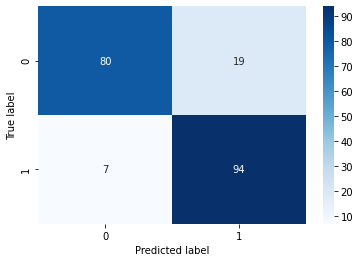

In [18]:
# Make predictions on the test set
test_predictions = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
test_predictions = np.round(test_predictions).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

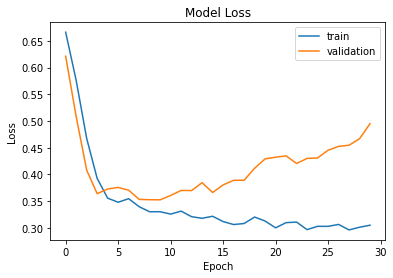

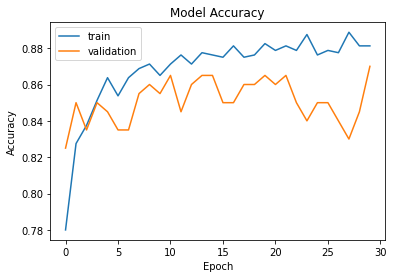

In [19]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Learning Rate

Epoch 1/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6870 - accuracy: 0.6488 - val_loss: 0.6781 - val_accuracy: 0.7200
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6734 - accuracy: 0.7175 - val_loss: 0.6656 - val_accuracy: 0.7450
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6598 - accuracy: 0.7688 - val_loss: 0.6513 - val_accuracy: 0.7800
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6456 - accuracy: 0.7937 - val_loss: 0.6358 - val_accuracy: 0.8150
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6298 - accuracy: 0.8200 - val_loss: 0.6188 - val_accuracy: 0.8350
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6127 - accuracy: 0.8288 - val_loss: 0.6013 - val_accuracy: 0.8350
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5945 - accuracy: 0.8288 - val_loss: 0.5820 - val_accuracy: 0.8400
Epoch 8/100


Epoch 59/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3280 - accuracy: 0.8675 - val_loss: 0.3703 - val_accuracy: 0.8650
Epoch 60/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3271 - accuracy: 0.8737 - val_loss: 0.3689 - val_accuracy: 0.8550
Epoch 61/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3266 - accuracy: 0.8712 - val_loss: 0.3701 - val_accuracy: 0.8650
Epoch 62/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3248 - accuracy: 0.8737 - val_loss: 0.3691 - val_accuracy: 0.8600
Epoch 63/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3239 - accuracy: 0.8725 - val_loss: 0.3696 - val_accuracy: 0.8550
Epoch 64/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3241 - accuracy: 0.8725 - val_loss: 0.3701 - val_accuracy: 0.8550
Epoch 65/100
16/16 [==============================] - 0s 7ms/step - loss: 0.3231 - accuracy: 0.8737 - val_loss: 0.3698 - val_accuracy: 0.8600
Epoch 

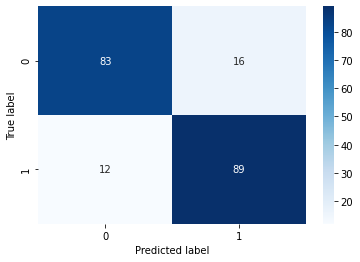

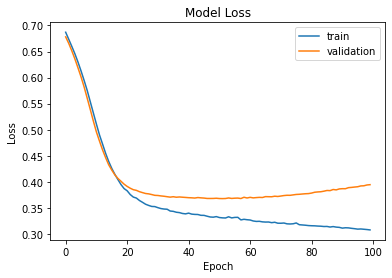

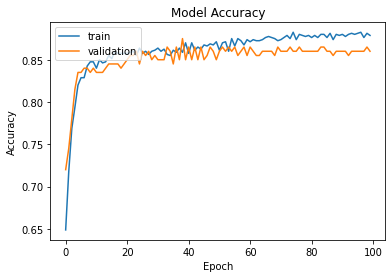

In [20]:
# Define the CNN architecture
model = keras.Sequential([
    Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(201, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

#---------------------- new code ------------
# Set the learning rate                                                                                                    
lr = 0.0001                                                                                                                
# Compile the model with a custom optimizer                                                                                
optimizer = Adam(learning_rate=lr)                                                                                         
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 
#-------------------------------------------


# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
test_predictions = np.round(test_predictions).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Early stopping:

Epoch 1/100
16/16 [==============================] - 1s 11ms/step - loss: 0.6912 - accuracy: 0.5038 - val_loss: 0.6854 - val_accuracy: 0.4950
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6816 - accuracy: 0.5050 - val_loss: 0.6769 - val_accuracy: 0.5050
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6740 - accuracy: 0.5088 - val_loss: 0.6685 - val_accuracy: 0.5100
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6655 - accuracy: 0.5175 - val_loss: 0.6593 - val_accuracy: 0.5400
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.6561 - accuracy: 0.6150 - val_loss: 0.6494 - val_accuracy: 0.6950
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6464 - accuracy: 0.7225 - val_loss: 0.6387 - val_accuracy: 0.7450
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6361 - accuracy: 0.7387 - val_loss: 0.6272 - val_accuracy: 0.7450
Epoch 8/100


Epoch 59/100
16/16 [==============================] - 0s 7ms/step - loss: 0.3314 - accuracy: 0.8700 - val_loss: 0.3536 - val_accuracy: 0.8700
Epoch 60/100
16/16 [==============================] - 0s 7ms/step - loss: 0.3308 - accuracy: 0.8675 - val_loss: 0.3535 - val_accuracy: 0.8700
Epoch 61/100
16/16 [==============================] - 0s 7ms/step - loss: 0.3304 - accuracy: 0.8712 - val_loss: 0.3534 - val_accuracy: 0.8700
Epoch 62/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3310 - accuracy: 0.8675 - val_loss: 0.3540 - val_accuracy: 0.8700
Epoch 63/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3305 - accuracy: 0.8737 - val_loss: 0.3534 - val_accuracy: 0.8700
Epoch 64/100
16/16 [==============================] - 0s 7ms/step - loss: 0.3298 - accuracy: 0.8725 - val_loss: 0.3539 - val_accuracy: 0.8700
Epoch 65/100
16/16 [==============================] - 0s 7ms/step - loss: 0.3283 - accuracy: 0.8700 - val_loss: 0.3544 - val_accuracy: 0.8650
Epoch 

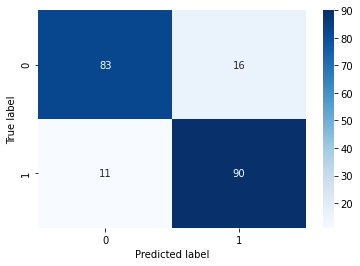

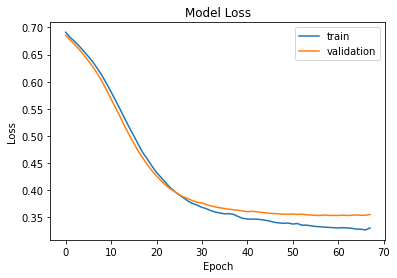

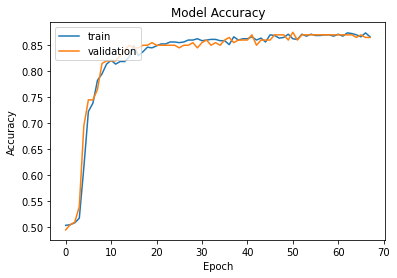

In [21]:
# Define the CNN architecture
model = keras.Sequential([
    Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(201, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

#---------------------- new code ------------
# Set the learning rate                                                                                                    
lr = 0.0001                                                                                                                
# Compile the model with a custom optimizer                                                                                
optimizer = Adam(learning_rate=lr)                                                                                         
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 

# Set up early stopping                                                                                                    
early_stop = EarlyStopping(monitor='val_loss', patience=5)              

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test), callbacks=[early_stop])
#-------------------------------------------



# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
test_predictions = np.round(test_predictions).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Dropout and more layers

Epoch 1/100
16/16 [==============================] - 1s 17ms/step - loss: 0.6926 - accuracy: 0.5038 - val_loss: 0.6921 - val_accuracy: 0.4950
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6917 - accuracy: 0.5013 - val_loss: 0.6910 - val_accuracy: 0.4950
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6910 - accuracy: 0.5050 - val_loss: 0.6899 - val_accuracy: 0.4950
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6900 - accuracy: 0.5050 - val_loss: 0.6882 - val_accuracy: 0.4950
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6880 - accuracy: 0.5038 - val_loss: 0.6859 - val_accuracy: 0.4950
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6867 - accuracy: 0.5038 - val_loss: 0.6836 - val_accuracy: 0.4950
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6842 - accuracy: 0.5075 - val_loss: 0.6809 - val_accuracy: 0.4950
Epoch 8/10

16/16 [==============================] - 0s 10ms/step - loss: 0.3706 - accuracy: 0.8587 - val_loss: 0.3453 - val_accuracy: 0.8550
Epoch 59/100
16/16 [==============================] - 0s 9ms/step - loss: 0.3788 - accuracy: 0.8388 - val_loss: 0.3554 - val_accuracy: 0.8350
Epoch 60/100
16/16 [==============================] - 0s 9ms/step - loss: 0.3657 - accuracy: 0.8500 - val_loss: 0.3490 - val_accuracy: 0.8550
Epoch 61/100
16/16 [==============================] - 0s 9ms/step - loss: 0.3534 - accuracy: 0.8600 - val_loss: 0.3566 - val_accuracy: 0.8350
Epoch 62/100
16/16 [==============================] - 0s 10ms/step - loss: 0.3662 - accuracy: 0.8512 - val_loss: 0.3487 - val_accuracy: 0.8550
Epoch 63/100
16/16 [==============================] - 0s 9ms/step - loss: 0.3616 - accuracy: 0.8500 - val_loss: 0.3589 - val_accuracy: 0.8350
Epoch 64/100
16/16 [==============================] - 0s 10ms/step - loss: 0.3606 - accuracy: 0.8537 - val_loss: 0.3498 - val_accuracy: 0.8500
Epoch 65/100
16/

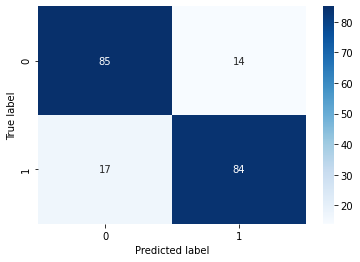

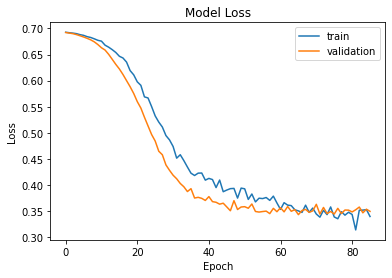

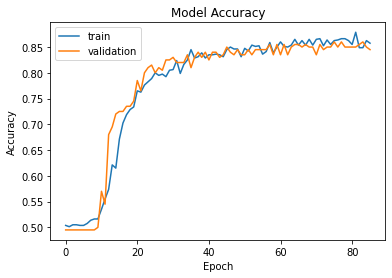

In [22]:
model = keras.Sequential([
    Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(201, 1)),
    MaxPooling1D(pool_size=4),                                                                                                                                       
    Dropout(0.2),                                                                                                                                                    
    Conv1D(filters=128, kernel_size=4, activation='relu'),                                                                
    MaxPooling1D(pool_size=4),                                                                                             
    Dropout(0.2),      
    Flatten(),                                                                                                             
    Dense(units=128, activation='relu'),                                        
    Dropout(0.2),                                                                                                         
    Dense(units=64, activation='relu'),                                                                                    
    Dropout(0.2),  
    Dense(units=32, activation='relu'), 
    keras.layers.Dense(units=1, activation='sigmoid')
])

#---------------------- new code ------------
# Set the learning rate                                                                                                    
lr = 0.00005                                                                                                                
# Compile the model with a custom optimizer                                                                                
optimizer = Adam(learning_rate=lr)                                                                                         
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 

# Set up early stopping                                                                                                    
early_stop = EarlyStopping(monitor='val_loss', patience=20)              

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test), callbacks=[early_stop])
#-------------------------------------------



# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
test_predictions = np.round(test_predictions).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Model checkpoints demo:

Epoch 1/20
25/25 [==============================] - 1s 11ms/step - loss: 0.6920 - accuracy: 0.5075 - val_loss: 0.6885 - val_accuracy: 0.4950
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5213 - val_loss: 0.6804 - val_accuracy: 0.4950
Epoch 3/20
25/25 [==============================] - 0s 7ms/step - loss: 0.6793 - accuracy: 0.5100 - val_loss: 0.6679 - val_accuracy: 0.4950
Epoch 4/20
25/25 [==============================] - 0s 7ms/step - loss: 0.6678 - accuracy: 0.5813 - val_loss: 0.6496 - val_accuracy: 0.6500
Epoch 5/20
25/25 [==============================] - 0s 7ms/step - loss: 0.6545 - accuracy: 0.6288 - val_loss: 0.6249 - val_accuracy: 0.7250
Epoch 6/20
25/25 [==============================] - 0s 7ms/step - loss: 0.6374 - accuracy: 0.7063 - val_loss: 0.5996 - val_accuracy: 0.7300
Epoch 7/20
25/25 [==============================] - 0s 7ms/step - loss: 0.6130 - accuracy: 0.7425 - val_loss: 0.5657 - val_accuracy: 0.7750
Epoch 8/20
25/25 [=

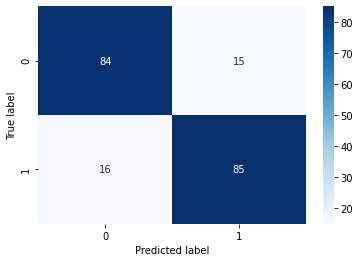

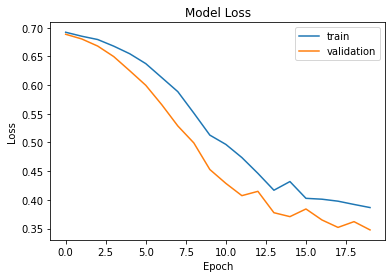

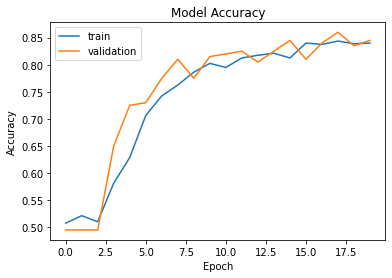

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint

#--- copy of previous CNN
model = keras.Sequential([
    Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(201, 1)),
    MaxPooling1D(pool_size=4),                                                                                                                                       
    Dropout(0.2),                                                                                                                                                    
    Conv1D(filters=128, kernel_size=4, activation='relu'),                                                                
    MaxPooling1D(pool_size=4),                                                                                             
    Dropout(0.2),      
    Flatten(),                                                                                                             
    Dense(units=128, activation='relu'),                                        
    Dropout(0.2),                                                                                                         
    Dense(units=64, activation='relu'),                                                                                    
    Dropout(0.2),  
    Dense(units=32, activation='relu'), 
    keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the learning rate                                                                                                    
lr = 0.0001 # changed it                                                                                                               
# Compile the model with a custom optimizer                                                                                
optimizer = Adam(learning_rate=lr)                                                                                         
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 


#---------------------- new code ------------
# define the checkpoint filepath
checkpoint_filepath = 'model_weights_{epoch:02d}.h5'

# define the ModelCheckpoint callback to save the weights
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True, save_freq='epoch')

# train the model using the checkpoint callback
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[checkpoint])

#------------------ copy of previous plotting code
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
test_predictions = np.round(test_predictions).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
# save and load old version

In [25]:
# assume that `model` is your trained CNN model
model.save('model_architecture.h5')

In [26]:
from tensorflow.keras.models import load_model

# Load the model architecture
model = load_model('model_architecture.h5')

# Load the weights at epoch 20
model.load_weights('model_weights_05.h5')

7/7 [==============================] - 0s 2ms/step - loss: 0.6249 - accuracy: 0.7250
Test accuracy: 0.7250000238418579
Confusion matrix:
[[96  3]
 [52 49]]


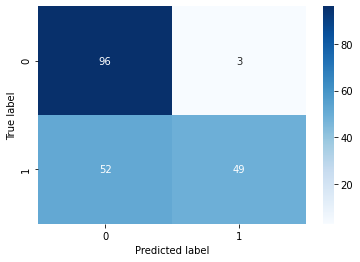

In [27]:
#------------------ copy of previous plotting code
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
test_predictions = np.round(test_predictions).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Tuning Hyperparameters: (don not run )

In [ ]:
Notes: 
Remaining things:
dropout layers
grid search
explain confusion matrix
model_checkpoints
activation functions